In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
def my_root_locus(G, kvect=None):
    "custom function for plotting rlocus, control library version is problematic"
    rlist, klist = control.rlocus(G, kvect=kvect, plot=False);
    poles = control.pole(G)
    zeros = control.zero(G)
    plt.plot(np.real(rlist), np.imag(rlist));
    plt.plot(np.real(poles), np.imag(poles), '.', ms=10, marker='x', mew=1, label='open loop poles')
    plt.plot(np.real(zeros), np.imag(zeros), '.', ms=10, marker='o', mew=1, label='open loop zeros')
    r0, k0 = control.rlocus(G, kvect=[1], plot=False);
    plt.plot(np.real(r0[0]), np.imag(r0[0]), '.', ms=10, marker='s', fillstyle='none', mew=1, label='closed loop poles');
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.grid();
    plt.legend()
    plt.axis('equal')

# Fan Model

Fan 1st order plant model, taking into account spool up time.

$G_{fan} = \dfrac{F}{u_{fan}} = F_{max} \dfrac{1}{\tau s + 1}$

where:

* $F_{max}$ is the fan maximum thrust
* $\tau$ is the spool up/spool down time for the fan, assumed to be the same here, in seconds
* $u_{fan}$ is the normalized [0-1] throttle command for the fan

In [3]:
tau = 0.1
thrust_max = 10
s = control.tf([1, 0], [1])
G_fan = thrust_max*(1/(tau*s+1))
G_fan

TransferFunction(array([10.]), array([0.1, 1. ]))

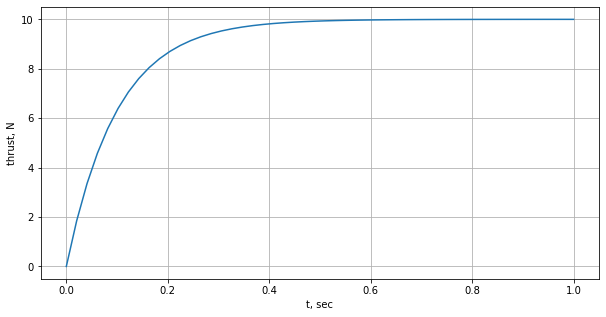

In [4]:
t, y = control.step_response(G_fan, T=np.linspace(0, 1));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('thrust, N')
plt.grid()

# Kinematic Model of Aicraft Roll

$M = J_{xx} \ddot{\phi}$

$M = J_{xx} s^2 \Phi$

$G_{roll} = \dfrac{\Phi}{M} = \dfrac{1}{J_{xx} s^2}$

# Mixing

$M = l(F_l - F_r)$

$M = l(G_{fan}u_{l} - G_{fan} u_{r})$

$u_{roll} = u_{l} - u_{r}$

$\dfrac{M}{u_{roll}} = l G_{fan}$

where:

* $l$ is the distance from the center of mass to the left and right lift fans, assumed to be at the same distance
* $F_{l/r}$ is the thrust of the left/right lift fan
* $u_{l/r}$ is the normalized [0-1] throttle command for the left/right lift fan
* $u_{roll}$ is the normalized [0-1] roll mix that we define

# Plant Model

$G = \dfrac{\Phi}{u_{roll}} =  \dfrac{\Phi}{M} \times \dfrac{M}{u_{roll}} = \dfrac{l G_{fan}}{J_{xx} s^2}$

In [5]:
l = 1
J_xx = 1
Gk = 1/(J_xx*s**2)
Gf = l*G_fan
G = Gf*Gk

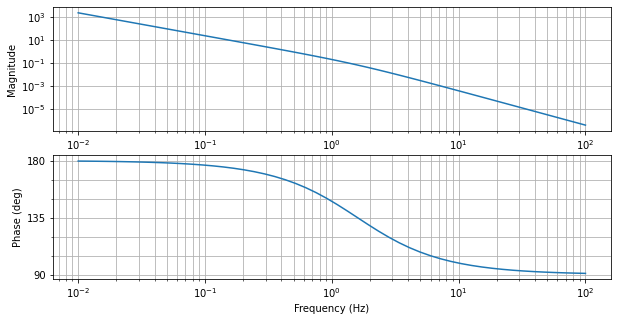

In [6]:
control.bode(G, omega=2*np.pi*np.logspace(-2, 2), Hz=True);

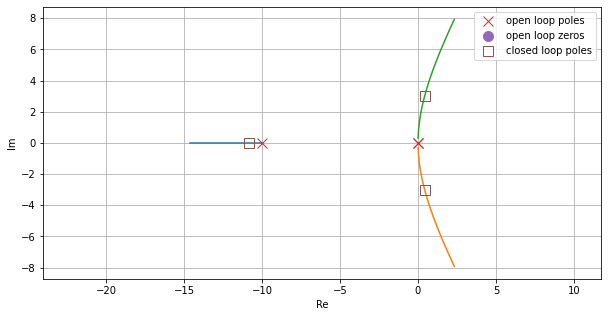

In [7]:
my_root_locus(G, kvect=np.logspace(-2, 1, 1000));

# Compensator

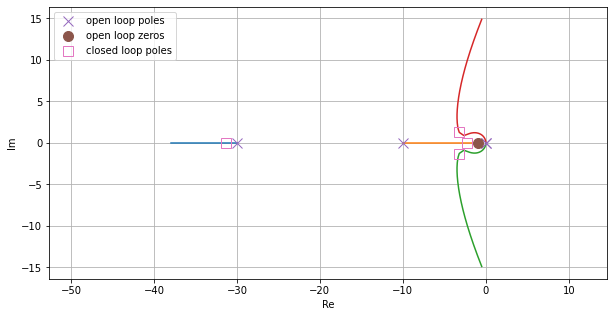

In [8]:
H = 0.29*(s/1 + 1)/(s/30 + 1)  # lead-lag
my_root_locus(G*H, np.logspace(-10, 1, 1000))

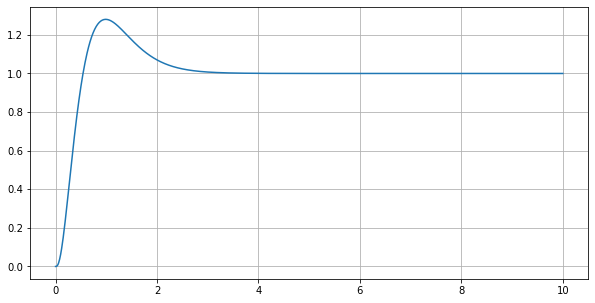

In [9]:
y_r = G*H/(1 + G*H)
t, y = control.step_response(y_r, T=np.linspace(0, 10, 1000))
plt.plot(t, y)
plt.grid()

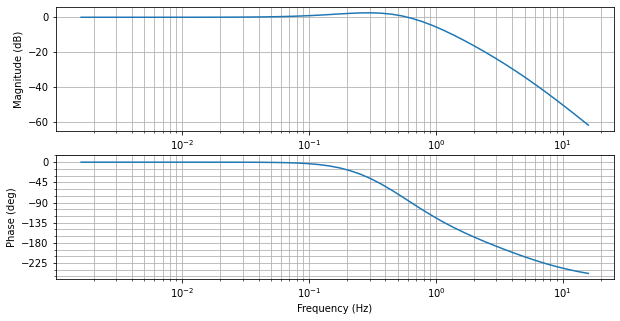

In [10]:
control.bode(y_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

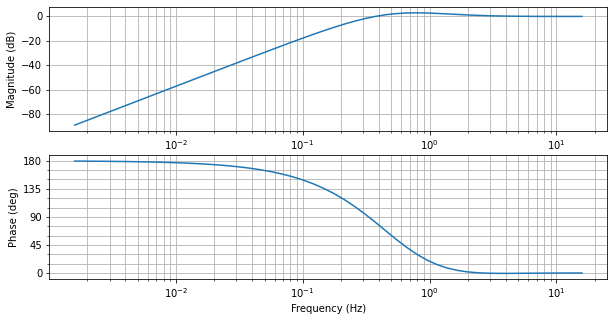

In [11]:
e_r = 1/(1 + G*H)
control.bode(e_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

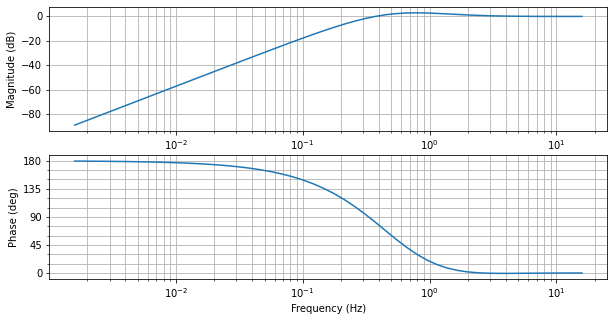

In [12]:
e_d = 1/(1 + G*H)
control.bode(e_d, omega=np.logspace(-2, 2), Hz=True, dB=True);

# Gang of 4

* $\dfrac{GH}{1 + GH}$ the complementary sensitivity function
* $\dfrac{G}{1 + GH}$ the load disturbance sensitivity function
* $\dfrac{H}{1 + GH}$ the noise sensitivity function
* $\dfrac{1}{1 + GH}$ the sensitivity function